In [1]:
import math
import numpy as np
import os
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler
from PIL import Image
from torch import nn
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomHorizontalFlip
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

# Setup
diffusion_model_id = 'runwayml/stable-diffusion-v1-5'
text_encoder_model_id = 'openai/clip-vit-large-patch14'
device = 'cuda'
seed = 1024

# Hugging Face access token
token = ''
with open('../hugging_face_token.txt', 'r') as secret:
    token = secret.readline().strip()

In [ ]:
# Load model components

# Text Encoder + Tokenizer
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_model_id)
text_encoder = CLIPTextModel.from_pretrained(text_encoder_model_id, torch_dtype=torch.float16)
text_encoder.to(device)

# Variational Autoencoder
vae = AutoencoderKL.from_pretrained(
    diffusion_model_id, subfolder='vae', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
vae.to(device)

# U-Net Model
u_net = UNet2DConditionModel.from_pretrained(
    diffusion_model_id, subfolder='unet', torch_dtype=torch.float16,
    revision='fp16', use_auth_token=token)
u_net.to(device)

In [3]:
# Freeze parameters for a model
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze all pre-trained models
freeze_params(text_encoder.parameters())
freeze_params(vae.parameters())
freeze_params(u_net.parameters())

In [4]:
# Noise Scheduler

#scheduler = DDIMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
#scheduler = LMSDiscreteScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
scheduler = PNDMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)
noise_scheduler = DDPMScheduler.from_config(diffusion_model_id, subfolder='scheduler', use_auth_token=token)

In [5]:
# Tokenize input prompt
def tokenize_prompt(prompt):
    text_inputs = tokenizer(
        prompt, padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    return text_inputs.input_ids.to(device)

# Encode input tokens
def encode_prompt(tokenized):
    with torch.no_grad():
        text_embeddings = text_encoder(tokenized)[0]
    return text_embeddings

# Prepare latents for denoising
def prepare_latents(height=512, width=512, latents=None):
    if latents is None:
        shape = (1, u_net.in_channels, height // 8, width // 8)
        latents = torch.randn(shape, device=device, dtype=torch.float16)
    latents = latents.to(device)
    latents *= scheduler.init_noise_sigma
    return latents

# Decode latents into an image
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

In [6]:
class PromptEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.prompt_layer = nn.Embedding(49408, 768, dtype=torch.float16)

    def forward(self, input):
        tokenized = tokenize_prompt(input)
        encoded = encode_prompt(tokenized)
        prompted = self.prompt_layer(tokenized)
        encoded_sum = (encoded * 0.7).add(prompted * 0.3)
        return encoded_sum

prompt_encoder = PromptEncoder().to(device)

In [7]:
class DiffusionDataset(Dataset):
    def __init__(
        self,
        data_root,
        repeats=10,  # 100
        flip_p=0.5,  # 0.5 default
        set='train',
    ):
        self.data_root = data_root
        self.img_root = f'{self.data_root}/dataset'
        self.flip_p = flip_p
        self.image_paths = sorted([os.path.join(self.img_root, file_path) for file_path in os.listdir(self.img_root)])
        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == 'train':
            self._length = self.num_images * repeats

        self.prompts = []
        with open(os.path.join(self.data_root, 'text_prompts.txt'), 'r') as prompt_file:
            self.prompts = prompt_file.readlines()
        self.flip_transform = RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}

        # Get image
        image = Image.open(self.image_paths[i % self.num_images])

        # Get text prompt
        text = self.prompts[i % self.num_images].strip()
        example['input_prompt'] = text

        # Prepare image
        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float16)
        example['pixel_values'] = torch.from_numpy(image).permute(2, 0, 1).to(device)
        return example

In [8]:
def train_model(data_root, num_train_epochs=100, batch_size=1, lr=0.001):
    # Initialize optimizer
    optimizer = torch.optim.SGD(prompt_encoder.parameters(), lr=lr)

    # Initialize dataset
    train_dataset = DiffusionDataset(
        data_root=data_root,
    )
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Learning rate scheduler
    max_train_steps = num_train_epochs * len(train_dataloader)
    lr_scheduler = LambdaLR(optimizer, lambda _: 1)

    # Training loop
    for epoch in range(num_train_epochs):
        for step, batch in enumerate(train_dataloader):
            # Convert images to latent space
            latents = vae.encode(batch['pixel_values']).latent_dist.sample()
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents
            noise = torch.randn(latents.shape, dtype=torch.float16).to(latents.device)
            bsz = latents.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
            ).long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            prompt_embeddings = prompt_encoder(batch['input_prompt'][0])

            # Predict the noise residual
            noise_pred = u_net(noisy_latents, timesteps, encoder_hidden_states=prompt_embeddings).sample

            if not (step % 10):
                """
                a = (decode_latents(noisy_latents) * 255).round().astype('uint8')[0]
                display(Image.fromarray(a))
                a = (decode_latents(noise) * 255).round().astype('uint8')[0]
                display(Image.fromarray(a))
                a = (decode_latents(noise_pred) * 255).round().astype('uint8')[0]
                display(Image.fromarray(a))
                """

            # Backwards pass
            loss = F.mse_loss(noise_pred, noise, reduction='none').mean([1, 2, 3]).mean()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Print logs
            logs = {'loss': loss.detach().item(),
                    'lr': lr_scheduler.get_last_lr()[0],
                    'epoch': epoch + 1,
                    'step': f'{step + 1}/{len(train_dataloader)}'}
            print(logs)

In [9]:
# Training
data_folder = '../../data/luffy'
train_model(data_folder, num_train_epochs=100, lr=0.001)

{'loss': 0.09063720703125, 'lr': 0.001, 'epoch': 1, 'step': '1/30'}
{'loss': 0.041015625, 'lr': 0.001, 'epoch': 1, 'step': '2/30'}
{'loss': 0.04296875, 'lr': 0.001, 'epoch': 1, 'step': '3/30'}
{'loss': 0.005702972412109375, 'lr': 0.001, 'epoch': 1, 'step': '4/30'}
{'loss': 0.02398681640625, 'lr': 0.001, 'epoch': 1, 'step': '5/30'}
{'loss': 0.2252197265625, 'lr': 0.001, 'epoch': 1, 'step': '6/30'}
{'loss': 0.0211639404296875, 'lr': 0.001, 'epoch': 1, 'step': '7/30'}
{'loss': 0.0736083984375, 'lr': 0.001, 'epoch': 1, 'step': '8/30'}
{'loss': 0.1461181640625, 'lr': 0.001, 'epoch': 1, 'step': '9/30'}
{'loss': 0.027099609375, 'lr': 0.001, 'epoch': 1, 'step': '10/30'}
{'loss': 0.0220947265625, 'lr': 0.001, 'epoch': 1, 'step': '11/30'}
{'loss': 0.2115478515625, 'lr': 0.001, 'epoch': 1, 'step': '12/30'}
{'loss': 0.008392333984375, 'lr': 0.001, 'epoch': 1, 'step': '13/30'}
{'loss': 0.0758056640625, 'lr': 0.001, 'epoch': 1, 'step': '14/30'}
{'loss': 0.474609375, 'lr': 0.001, 'epoch': 1, 'step': 

In [10]:
def eval_model(prompt, num_inference_steps=50, guidance_scale=7.5):
    # Set random seed
    torch.manual_seed(seed)

    # Encode input prompt
    prompt_embeddings = prompt_encoder(prompt)

    # Add unconditional embeddings for guidance scale
    unconditional_input = tokenizer(
        [''], padding='max_length', max_length=tokenizer.model_max_length,
        truncation=True, return_tensors='pt')
    unconditional_embeddings = text_encoder(unconditional_input.input_ids.to(device))[0]

    # Concatenate for final embeddings
    text_embeddings = torch.cat([unconditional_embeddings, prompt_embeddings])

    # Prepare timesteps
    scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = scheduler.timesteps

    # Prepare latent variables
    latents = prepare_latents()

    # Denoising Loop
    for i, t in enumerate(tqdm(timesteps)):
        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = u_net(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_unconditional, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_unconditional + guidance_scale * (noise_pred_text - noise_pred_unconditional)

        # Compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents
    decoded = decode_latents(latents)

    # Return image
    images = (decoded * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

  0%|          | 0/51 [00:00<?, ?it/s]

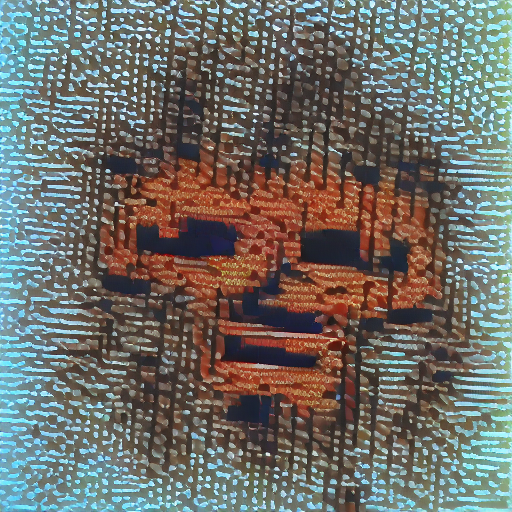

In [11]:
# Inference
prompt = 'sun god luffy'
generated_img = eval_model(prompt, guidance_scale=7.5)
generated_img.save('test.png')
generated_img